In [1]:
import ngsolve as ngs
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt

from createGeom import makeGeo
geoOCC = makeGeo()

ngmesh = geoOCC.GenerateMesh()
mesh = ngs.Mesh(ngmesh)

# mesh.Refine()
# mesh.Refine()
# mesh.Curve(2)


In [2]:
# Draw(mesh)

In [3]:
from bhdata import BHCurves
fun_dw  = BHCurves(4)
fun_w   = fun_dw.Integrate()
fun_ddw = fun_dw.Differentiate()

mu0 = 1.256636e-6
nu0 = 1/mu0

linear = "coil_plus|coil_minus"
nonlinear = "stator"

strom = 1e5
amps = 0.025**2*3.15*strom
print(f'Applying a current of {amps:.2f} Amps')
# Draw(J, mesh)

BH data from TEAM 13 problem
Applying a current of 196.88 Amps


Using 3D mesh with ne= 1057 elements and nv= 307 points and  6242 DOFs.
 


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

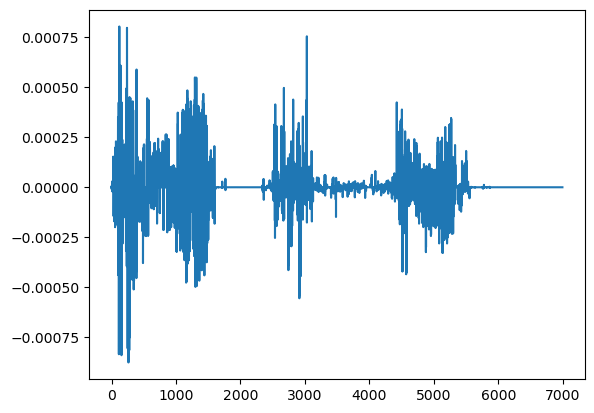

In [4]:
from do import solve
from copy import deepcopy

levels = 2
deg = 2

ngmesh = geoOCC.GenerateMesh()
mesh = ngs.Mesh(ngmesh)

HCurl = ngs.HCurl(mesh, order = deg, nograds = True, dirichlet = 'outer_face|coil_plus_face|coil_minus_face|stator_face')
HCurlN = ngs.HCurl(mesh, order = deg)
V3L2 = ngs.HDiv(mesh, order = deg-1)
VL2 = ngs.L2(mesh, order = deg-1)

# A = []; B = []; it = []; 
# for i in range(levels):
#     print(f"i = {i:d}")
#     # mesh.Curve(2)
    
#     J = mesh.MaterialCF({'coil_plus': (0,0,strom), 'coil_minus': (0,0,-strom), 'stator': (0,0,0)}, default = (0,0,0))

#     Ai = ngs.GridFunction(HCurl, autoupdate = True, nested = True)
#     Ai, Bi, iti = solve(HCurl,Ai,mesh,deg,J,fun_w,fun_dw,fun_ddw)

#     Bi = ngs.GridFunction(V3L2, autoupdate = True, nested = True)
#     with ngs.TaskManager(): Bi.Set(ngs.curl(Ai))

#     clipping = { "function" : True, "z" : -0.4}
#     with ngs.TaskManager(): Draw(Bi, mesh, clipping = clipping)

#     # deepcopy(Ai)

#     A.append(Ai)
#     B.append(Bi)
#     it.append(iti)

#     if i!= levels-1: mesh.Refine()



J = mesh.MaterialCF({'coil_plus': (0,0,strom), 'coil_minus': (0,0,-strom), 'stator': (0,0,0)}, default = (0,0,0))
A0 = ngs.GridFunction(HCurl)
A0, it0 = solve(HCurl,A0,mesh,deg,J,fun_w,fun_dw,fun_ddw)

# A00 = ngs.GridFunction(HCurlN, nested = False, autoupdate = False)
# A00.Set(deepcopy(A0))

B0 = ngs.GridFunction(V3L2)
with ngs.TaskManager(): B0.Set(ngs.curl(A0))

clipping = { "function" : True, "z" : -0.4}
# with ngs.TaskManager(): Draw(B0, mesh, clipping = clipping)
with ngs.TaskManager(): Draw(B0, mesh, clipping = clipping)

# data_B0 = B0.vec.data.FV().NumPy()
# plt.figure()
# plt.plot(data_B0)
# print(data_B0.shape,mesh.ne)


plt.figure()
plt.plot(B0.vec.data.FV().NumPy())




# J = mesh.MaterialCF({'coil_plus': (0,0,strom), 'coil_minus': (0,0,-strom), 'stator': (0,0,0)}, default = (0,0,0))
# A1 = ngs.GridFunction(HCurl)
# A1, it1 = solve(HCurl,A1,mesh,deg,J,fun_w,fun_dw,fun_ddw)
# B1 = ngs.GridFunction(V3L2, nested = False, autoupdate = False)
# with ngs.TaskManager(): B1.Set(ngs.curl(A1))

# clipping = { "function" : True, "z" : -0.4}
# with ngs.TaskManager(): Draw(B1, mesh, clipping = clipping)



# data_B1 = B1.vec.data.FV().NumPy()
# plt.figure()
# plt.plot(data_B1)
# print(data_B1.shape,mesh.ne)






# B01 = ngs.GridFunction(VL2, nested = False)
# with ngs.TaskManager(): B01.Set(B0[0])
# clipping = { "function" : True, "z" : -0.4}
# with ngs.TaskManager(): Draw(B01, mesh, clipping = clipping)





# mesh.Refine()
# J = mesh.MaterialCF({'coil_plus': (0,0,strom), 'coil_minus': (0,0,-strom), 'stator': (0,0,0)}, default = (0,0,0))
# A2 = ngs.GridFunction(HCurl)
# A2, it1 = solve(HCurl,A2,mesh,deg,J,fun_w,fun_dw,fun_ddw)
# B2 = ngs.GridFunction(V3L2, nested = True)
# with ngs.TaskManager(): B2.Set(ngs.curl(A2))

# clipping = { "function" : True, "z" : -0.4}
# with ngs.TaskManager(): Draw(B2, mesh, clipping = clipping)



In [5]:
# mesh2 = ngs.Mesh(ngmesh)
mesh.Refine()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

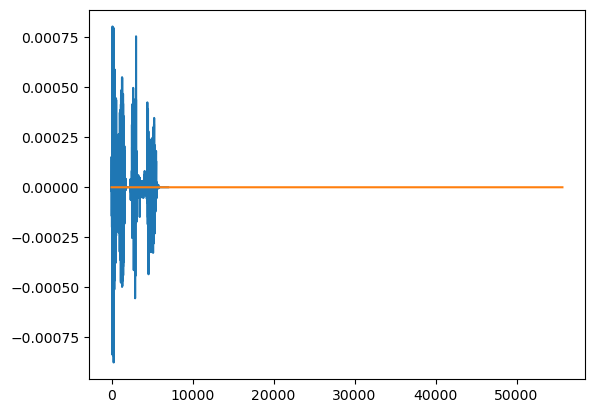

In [6]:
V3L2 = ngs.HDiv(mesh, order = deg-1)

u, v = V3L2.TnT()
a = ngs.BilinearForm(V3L2)
a += u*v*ngs.dx()
a.Assemble()

# f = ngs.LinearForm(V3L2)
# f += B0*v*ngs.dx()
# f.Assemble()

f = ngs.LinearForm(V3L2)
f += ngs.SymbolicLFI(B0*v)
f.Assemble()



B01 = ngs.GridFunction(V3L2)
with ngs.TaskManager(): B01.vec.data = a.mat.Inverse(freedofs = V3L2.FreeDofs(), inverse="pardiso")*f.vec

clipping = { "function" : True, "z" : -0.4}
with ngs.TaskManager(): Draw(B01, mesh, clipping = clipping)


plt.plot(B0.vec.data.FV().NumPy())
plt.plot(B01.vec.data.FV().NumPy())

In [7]:
stop

B01 = ngs.GridFunction(V3L2)
B01.Set(B0)

clipping = { "function" : True, "z" : -0.4}
with ngs.TaskManager(): Draw(B01, mesh, clipping = clipping)



NameError: name 'stop' is not defined

In [ ]:
# import matplotlib.pyplot as plt

# data_B0 = B0.vec.data.FV().NumPy()

# plt.plot(data_B0)
# print(data_B0.shape,mesh.ne)

import numpy as np


B01 = ngs.GridFunction(VL2)
B01.vec.data = np.tile(B0.vec.data.FV().NumPy()[0::3].copy(),8) # I really don't know why i need "copy" here, but I do.
# B01.Set(B0[0])


#= np.tile(B0.vec.data.FV().NumPy(),4)
# np.tile(B0.vec.data.FV().NumPy(),8).shape

plt.figure()
plt.plot(B01.vec.data.FV())
plt.figure()
plt.plot(B0.vec.data.FV().NumPy()[0::3])
# plt.figure()
# plt.plot(B01.vec.data.FV().NumPy()-B0.vec.data.FV().NumPy()[0::3])

print(mesh.ne, B01.vec.data.size, B0.vec.data.size, B0.vec.data.FV().NumPy().size)
clipping = { "function" : True, "z" : -0.4}
with ngs.TaskManager(): Draw(B01, mesh, clipping = clipping)

B0.Update()
with ngs.TaskManager(): Draw(B0, mesh, clipping = clipping)

A00.Update()
with ngs.TaskManager(): Draw(ngs.curl(A00), mesh, clipping = clipping)

In [ ]:
print(B0.vec.data.FV().NumPy().reshape(3400,3)[:,0])
print(B0.vec.data.FV().NumPy()[:3400])
print(B0.vec.data.FV().NumPy()[0::3])

In [ ]:
clipping = {"z" : -1, "dist": 0}

# B0.Update()
# B1.Update()
with ngs.TaskManager(): Draw(B0, mesh, clipping = clipping)
with ngs.TaskManager(): Draw(B1, mesh, clipping = clipping)
with ngs.TaskManager(): Draw(B2, mesh, clipping = clipping)

In [ ]:
import numpy as np

err = np.zeros(levels-1)
for i in range(levels-1):
    with ngs.TaskManager():
        err[i] = ngs.Integrate((B[i+1]-B[i])**2,mesh)**(1/2)/ngs.Integrate((B[i+1])**2,mesh)**(1/2)

In [ ]:
print(np.log2(err[:-1]/err[1:]))
print(err)
print(it)

# [2.36188414]
# [0.13807031 0.02685977]
# [8, 8, 8]

In [ ]:
clipping = { "function" : True, "z" : -0.4}
with ngs.TaskManager():
    Draw (B[0]-B[1], mesh, clipping = clipping)



In [ ]:
!pip list

In [ ]:
clipping = { "function" : True, "z" : -0.4}

HDiv = ngs.HDiv(mesh, order = deg, dirichlet = 'outer_face|coil_plus_face|coil_minus_face|stator_face')
B0 = ngs.GridFunction(HDiv)
B0.Set(B[1])

with ngs.TaskManager():
    Draw (B[0], mesh, clipping = clipping)
    Draw (B[1], mesh, clipping = clipping)

In [ ]:
# !pip install -U webgui-jupyter-widgets

In [ ]:
# help(ngs.GridFunction)

# from ngsolve import *
from netgen.occ import unit_cube as uc
# from netgen.occ import unit_square as uc

import ngsolve as ngs
from ngsolve.webgui import Draw

mesh = ngs.Mesh(uc.GenerateMesh(maxh=0.1))
fes = ngs.HCurl(mesh, order = 0, autoupdate = True)

gf_u1 = ngs.GridFunction(fes, autoupdate = True, nested = True)
# gf_u1 = ngs.GridFunction(fes, autoupdate = False, nested = True)
gf_u1.Set((ngs.cos(ngs.x)*ngs.cos(ngs.y)*ngs.cos(ngs.z),0,0))
# gf_u1.Set(ngs.cos(ngs.x*ngs.y))


hv = gf_u1.vec.CreateVector(copy=True)
hv.data = gf_u1.vec

# print("gf_u1.vec.FV().NumPy():\n", gf_u1.vec.FV().NumPy())
# mesh.Refine()
# mesh.Refine()
# print("gf_u1.vec.FV().NumPy():\n", gf_u1.vec.FV().NumPy())
# Draw(ngs.div(gf_u1), mesh)

mesh.Refine()
# prol = fes.Prolongation()
# gf_u1.vec.Range(0,len(hv)).data = hv
# prol.Prolongate(1, gf_u1.vec)

clipping = { "function" : True, "z" : -0.4}
# Draw(gf_u1, clipping = clipping)

In [ ]:
Draw(gf_u1, clipping = clipping)

In [ ]:
minB1 = B1.vec.data.FV().NumPy().max()
maxB1 = B1.vec.data.FV().NumPy().min()

print(minB1, maxB1)

B1.Update()


In [ ]:
!pip install ngsolve==6.2.2204